In [208]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time


sys.path.insert(1, '../../modules')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *
from dis_flopy import *

In [621]:
#geo parameters
MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

#Z
nlay = 1

#X
x_seashore = 705e3
Lx_1 = x_seashore-x0
Lx_2 = x1 - x_seashore
res_1 = 300
res_2 = 600
ncol1 = int(Lx_1/res_1)
ncol2 = int(Lx_2/res_2)
ncol = ncol1+ncol2

delr = np.ones(ncol)*res_1
delr[ncol1:ncol1+1] *=1.5
delr[ncol1+1:] *= 2


#Y
Ly = y1-y0
res = 300
nrow = int(Ly/res)
delc = np.ones(nrow)*res

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [600]:
# load differents surfaces

top = "../../data/surfaces_geoter/TOPO (inf_0 en mer).ASC"
surfQ  = "../../data/surfaces_geoter/Mur QUAT.ASC"
surfPC = "../../data/surfaces_geoter/Mur PC.ASC"
surfPMS = "../../data/surfaces_geoter/Mur PMS.ASC"

files_surf = [top,surfQ,surfPC,surfPMS]
surfaces=[]
for file in files_surf:
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))
top = surfaces[0]
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]

In [622]:
BOT = PMS.copy()
BOT[PMS==-9999] = PC[PMS==-9999]
BOT[PC==-9999] = Q[PC==-9999]
BOT[BOT==-9999] = top[BOT==-9999] - 50



In [623]:
idomain=np.zeros([nlay+1,nrow,ncol])
idomain[0][BOT<1000] = 1

In [624]:
#BOT[(top-BOT)<=0] = top[(top-BOT)<=0] - 10 # minimum of 10 m thickness to avoid bug and numerical issues

In [625]:
botm = np.ones([nlay+1,nrow,ncol])
botm[0] = top
botm[1] = BOT
new_botm,new_idomain = multi_lay(botm,idomain,ep=10,nsublay=20,layer=1)

In [626]:
MinThick(new_idomain,new_botm,top)
check_thk(top,new_botm)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [627]:
new_botm=new_botm[1:]
new_idomain = new_idomain[1:]
nlay=new_botm.shape[0]

In [628]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if new_idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))

In [586]:
#recharge
rch_path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(rch_path,grid)

In [551]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True,layer=0)

# attribute a constant head at all the cells in the lst_chd
chd_lst=[];
for x in lst_chd:
    if x in lst_domain:
        chd_lst.append((x,0.1))

In [629]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=new_botm,xorigin=x0,yorigin=y0,idomain=new_idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="complex")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=new_botm+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=1e-4,save_flows=True)
# recharge
rch = fp.mf6.ModflowGwfrcha(gwf,pname = "rch",recharge=rcha/1000/365/86400,save_flows=True)

#constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

In [630]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model multi_couches...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rch...
    writing package sea...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to 

(False, [])

<a list of 13 text.Text objects>

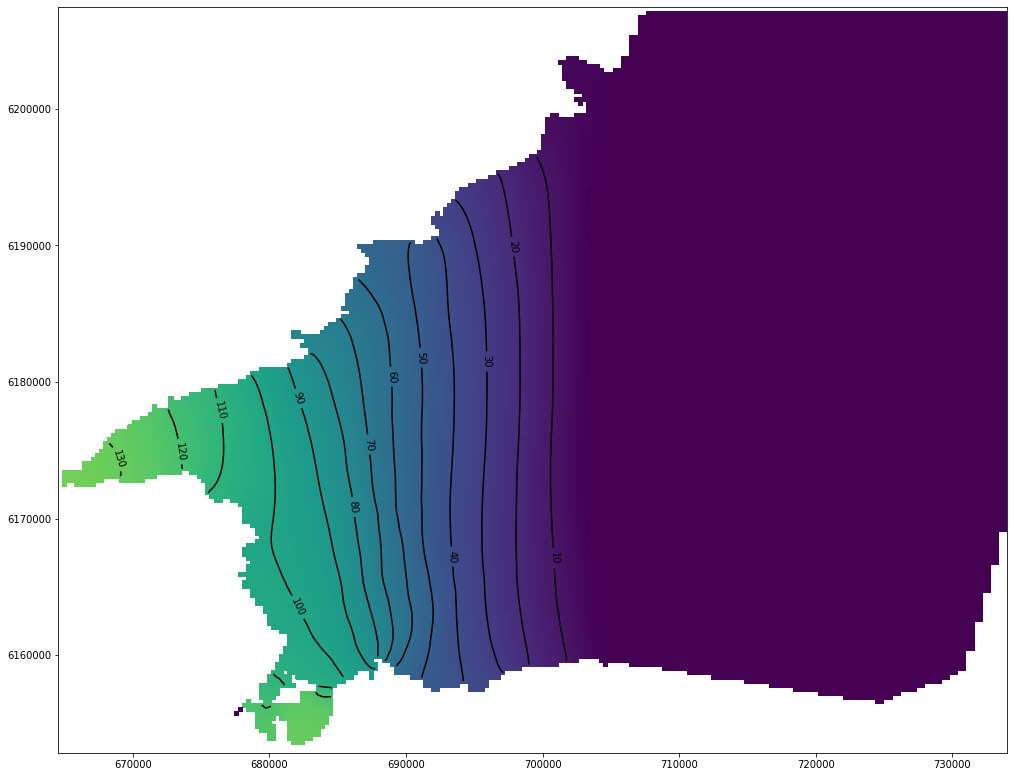

In [619]:
# retrieve heads
head = get_heads(model_name,model_dir)

# initialize plot
fig = plt.figure(figsize=(17,15))
layer = 0
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)

#plot heads
hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")


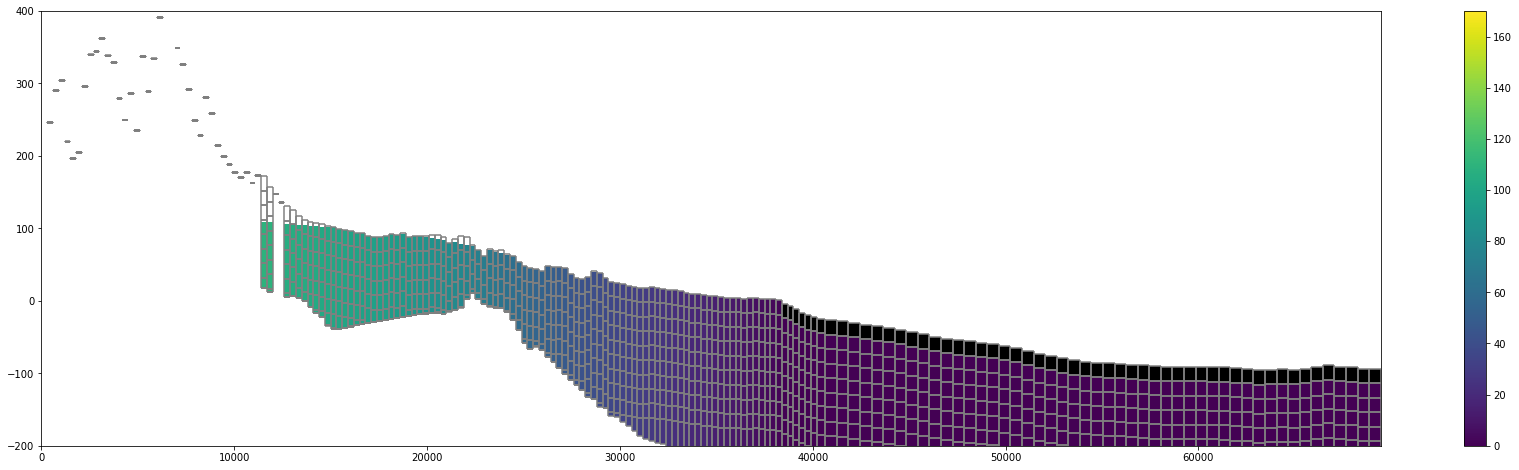

In [620]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :120})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,400)
x.plot_bc("sea")